Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, tolerance=1e-4):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.tolerance = tolerance
        self.theta = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def calculate_gradient(self, X, y, theta):
        m = len(y)
        z = np.dot(X, theta)
        h = self.sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / m
        return gradient
    
    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)  # Initialize weights with zeros
        prev_cost = float('inf')  # ensures that the first iteration of will certainly lead to a decrease in the cost function.
        
        for iteration in range(self.num_iterations):
            gradient = self.calculate_gradient(X, y, self.theta)
            self.theta -= self.learning_rate * gradient
            
            # Calculate the cost function (log-likelihood)
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

            # Print cost to monitor convergence
            if iteration % 50 == 0:
                print(f"Iteration {iteration}: CostFuntion = {cost:.5f}")
            
            # Check for convergence based on tolerance
            if abs(prev_cost - cost) < self.tolerance:
                print(f"Converged after {iteration + 1} iterations.")
                break
            
            prev_cost = cost
        return self.theta
    
    def predict(self, X):
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        # Use a threshold of 0.5 for binary classification
        predictions = (h >= 0.5).astype(int)
        return predictions
    
    def predict_proba(self, X):
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        return h

In [2]:
import pandas as pd
df = pd.read_csv("./datasets/heartdisease.csv")
print(list(df.columns))
print(df.shape)
df.head()

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
categorical = df.select_dtypes(include=['object']).columns.to_list()
numerical = df.select_dtypes(include=['number']).columns.to_list()
# print(categorical, numerical, sep="\n")
# Get the number of unique values in each column
unique_counts = df.nunique()
# print(unique_counts)

# Filter for columns with less than 10 unique values
columns_with_less_than_10_unique = unique_counts[unique_counts < 10]
encoding_df = df[columns_with_less_than_10_unique.index].drop(columns=["HeartDisease"])
# print(encoding_df.columns.to_list())

# Get distinct values for all columns
distinct_values = [[col, encoding_df[col].unique()] for col in encoding_df.columns]
# Create a DataFrame from the list of distinct values
distinct_df = pd.DataFrame(distinct_values, columns=['Column Name', 'Distinct Values'])
print(distinct_df)

# # Print distinct values in each column
# for column in encoding_df.columns:
#     distinct_values = encoding_df[column].unique()
#     print(f"Distinct values in {column}: {distinct_values}")

      Column Name      Distinct Values
0             Sex               [M, F]
1   ChestPainType  [ATA, NAP, ASY, TA]
2       FastingBS               [0, 1]
3      RestingECG    [Normal, ST, LVH]
4  ExerciseAngina               [N, Y]
5        ST_Slope     [Up, Flat, Down]


In [48]:
dataset = df.copy()
print("total #features with target:",len(dataset.columns.to_list()))
print(dataset.shape)
target_column = "HeartDisease"
# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8
# Calculate the number of rows for the training set
train_size = int(len(df) * split_ratio)
# Create a random permutation of row indices
indices = np.random.permutation(len(df))
# Split the indices into training and testing indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Create the training and testing DataFrames
X_train_df = dataset.drop(columns=[target_column]).iloc[train_indices]
X_test_df = dataset.drop(columns=[target_column]).iloc[test_indices]

y_train_df = dataset[target_column].iloc[train_indices]
y_test_df = dataset[target_column].iloc[test_indices]

# Optionally, reset the index for the new DataFrames if needed
X_train_df.reset_index(drop=True, inplace=True)
X_test_df.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
print(X_train_df[:2].to_numpy(), y_train_df[:2], sep="\n")


total #features with target: 12
(918, 12)
[[57 'M' 'NAP' 105 0 1 'Normal' 148 'N' 0.3 'Flat']
 [69 'M' 'ASY' 135 0 0 'Normal' 130 'N' 0.0 'Flat']]
0    1
1    1
Name: HeartDisease, dtype: int64


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

categorical_features = encoding_df.columns.to_list()
# Define your preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('onehot-encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
                    ('onehot-transformer', categorical_transformer, categorical_features)])
# Create the full pipeline with preprocessing and the model
model = Pipeline(steps=[('data-preprocessor', preprocessor),
                        ('model', LogisticRegression(learning_rate=0.1, num_iterations=500, tolerance=1e-4)
                         )])

In [19]:
print(X_train_df.shape, y_train_df.shape, sep="\n")
model.fit(X_train_df, y_train_df)

(734, 11)
(734,)
Iteration 0: CostFuntion = 0.68111
Iteration 50: CostFuntion = 0.44067
Iteration 100: CostFuntion = 0.38804
Iteration 150: CostFuntion = 0.36825
Iteration 200: CostFuntion = 0.35859
Converged after 235 iterations.


Pipeline(steps=[('data-preprocessor',
                 ColumnTransformer(transformers=[('onehot-transformer',
                                                  Pipeline(steps=[('onehot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 <__main__.LogisticRegression object at 0x000001FBF577DAC0>)])

In [23]:
theta = model.named_steps['model'].theta
theta

array([-0.48858088,  0.54702757,  0.92081033, -0.59696147, -0.29982772,
        0.03442556, -0.42802396,  0.48647065,  0.05897811, -0.16112   ,
        0.16058858, -0.53777062,  0.59621731,  0.16613271,  0.93525698,
       -1.042943  ])

In [24]:
y_pred = model.predict(X_test_df)
y_pred_proba = model.predict_proba(X_test_df)
# Calculate accuracy
print(y_pred.shape, y_pred_proba.shape, sep="\n")
accuracy = np.mean(y_pred == y_test_df)
print(f"Accuracy: {accuracy*100:.2f}%")

(184,)
(184,)
Accuracy: 87.50%


In [25]:
# Define a function for inferencing with the model
def predict_with_model(input_data, model):
    if isinstance(input_data, dict):
        # If input is a dictionary, convert it to a DataFrame with a single row
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, list):
        # If input is a list, check if it's a list of dictionaries or a list of scalar values
        if isinstance(input_data[0], dict):
            # If it's a list of dictionaries, convert it to a DataFrame
            input_df = pd.DataFrame(input_data)
        else:
            # If it's a list of scalar values, assume it's a single row of data
            # and convert it to a DataFrame with appropriate column names
            input_df = pd.DataFrame([input_data], columns=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
    
    X_input = input_df
    # Make predictions on the input data
    try:
        predictions = model.predict(X_input)
        # Or, if you need class probabilities (for classifiers)
        probabilities = model.predict_proba(X_input)

        return predictions, probabilities  # Return the model's predictions
    except TypeError as te:
        predictions = model.predict(pd.DataFrame(input_data))
        probabilities = model.predict_proba(pd.DataFrame(input_data))
        
        return predictions, probabilities

# Example usage
# 1. Single dictionary
input_dict1 = {
    'Age': 58,
    'Sex': 'F',
    'ChestPainType': 'ATA',
    'RestingBP': 180,
    'Cholesterol': 393,
    'FastingBS': 0,
    'RestingECG': 'Normal',
    'MaxHR': 110,
    'ExerciseAngina': 'Y',
    'Oldpeak': 1.0,
    'ST_Slope': 'Flat'
}

# 2. List of dictionaries
input_dict2 = [
    {
        'Age': 58,
        'Sex': 'F',
        'ChestPainType': 'ATA',
        'RestingBP': 180,
        'Cholesterol': 393,
        'FastingBS': 0,
        'RestingECG': 'Normal',
        'MaxHR': 110,
        'ExerciseAngina': 'Y',
        'Oldpeak': 1.0,
        'ST_Slope': 'Flat'
    },
    {
        'Age': 23,
        'Sex': 'F',
        'ChestPainType': 'ata',
        'RestingBP': 180,
        'Cholesterol': 213,
        'FastingBS': 1,
        'RestingECG': 'Normal',
        'MaxHR': 119,
        'ExerciseAngina': 'N',
        'Oldpeak': 0.0,
        'ST_Slope': 'Flat'
    }
]

# 3. List of dictionaries with series
input_dict3 = {
        'Age': [58, 23],
        'Sex': ['F', 'F'],
        'ChestPainType': ['ATA', 'ata'],
        'RestingBP': [180, 180],
        'Cholesterol': [393, 213],
        'FastingBS': [0, 1],
        'RestingECG': ['Normal', 'Normal'],
        'MaxHR': [110, 119],
        'ExerciseAngina': ['Y', 'N'],
        'Oldpeak': [1.0, 0.0],
        'ST_Slope': ['Flat', 'Flat']
    }

# 4. List
input_list = [58, 'F', 'ATA', 180, 393, 0, 'Normal', 110, 'Y', 1.0, 'Flat']

output1, proba1 = predict_with_model(input_dict1, model)
output2, proba2 = predict_with_model(input_dict2, model)
output3, proba3 = predict_with_model(input_dict3, model)
output4, proba4 = predict_with_model(input_list, model)

print(output1, proba1)
print(output2, proba2)
print(output3, proba3)
print(output4, proba4)

[0] [0.46425806]
[0 1] [0.46425806 0.55829768]
[0 1] [0.46425806 0.55829768]
[0] [0.46425806]


Metrics

Available metrics: ['accuracy', 'precision', 'recall', 'f1_score']
Accuracy: 87.50%
Precision: 85.58%
Recall: 91.75%
F1_score: 88.56%
Confusion_matrix:
[[89 15]
 [ 8 72]]
ROC AUC Score: 0.93


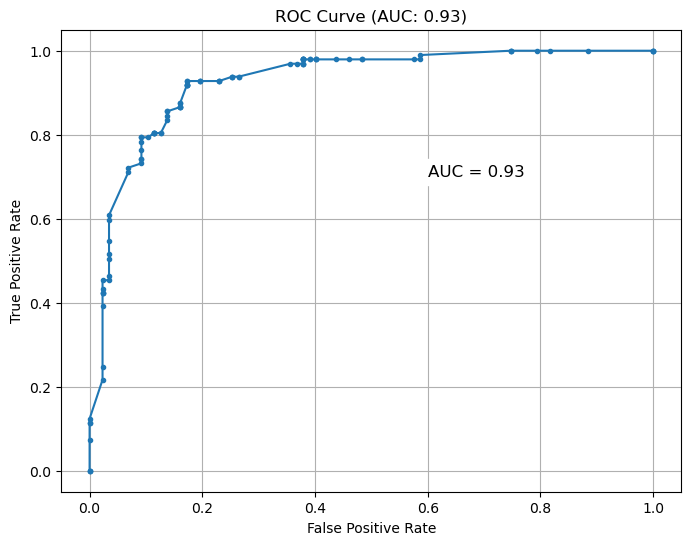

In [26]:
def calculate_accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

def calculate_precision(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_positives = np.sum((y_pred == 1) & (y_true == 0))
    return true_positives / (true_positives + false_positives)

def calculate_recall(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_negatives = np.sum((y_pred == 0) & (y_true == 1))
    return true_positives / (true_positives + false_negatives)

def calculate_f1_score(y_pred, y_true):
    precision = calculate_precision(y_pred, y_true)
    recall = calculate_recall(y_pred, y_true)
    return 2 * (precision * recall) / (precision + recall)

def calculate_confusion_matrix(y_pred, y_true):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    false_positives = np.sum((y_pred == 1) & (y_true == 0))
    true_negatives = np.sum((y_pred == 0) & (y_true == 0))
    false_negatives = np.sum((y_pred == 0) & (y_true == 1))

    return np.array([[true_positives, false_positives], [false_negatives, true_negatives]])

def calculate_metric(metric_name, y_pred, y_true):
    if metric_name == "accuracy":
        return calculate_accuracy(y_pred, y_true)
    elif metric_name == "precision":
        return calculate_precision(y_pred, y_true)
    elif metric_name == "recall":
        return calculate_recall(y_pred, y_true)
    elif metric_name == "f1_score":
        return calculate_f1_score(y_pred, y_true)
    elif metric_name == "confusion_matrix":
        return calculate_confusion_matrix(y_pred, y_true)
    elif metric_name == "list_metrics":
        return ["accuracy", "precision", "recall", "f1_score"]
    else:
        raise ValueError(f"Invalid metric name. Available metrics: {', '.join(calculate_metric('list_metrics', None, None))}")

def calculate_metrics(y_pred, y_true):
    metrics = {}
    metrics["accuracy"] = calculate_accuracy(y_pred, y_true)
    metrics["precision"] = calculate_precision(y_pred, y_true)
    metrics["recall"] = calculate_recall(y_pred, y_true)
    metrics["f1_score"] = calculate_f1_score(y_pred, y_true)
    metrics["confusion_matrix"] = calculate_confusion_matrix(y_pred, y_true)
    return metrics

def calculate_roc_auc(y_prob, y_true, plot=False):
    thresholds = np.linspace(0, 1, 100)  # Threshold values
    tpr_list = []  # True Positive Rate (Sensitivity)
    fpr_list = []  # False Positive Rate

    for threshold in thresholds:
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        true_positives = np.sum((y_pred_thresholded == 1) & (y_true == 1))
        false_positives = np.sum((y_pred_thresholded == 1) & (y_true == 0))
        true_negatives = np.sum((y_pred_thresholded == 0) & (y_true == 0))
        false_negatives = np.sum((y_pred_thresholded == 0) & (y_true == 1))

        tpr = true_positives / (true_positives + false_negatives)
        fpr = false_positives / (false_positives + true_negatives)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = calculate_auc(tpr_list, fpr_list)
    print(f"ROC AUC Score: {auc:.2f}")
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_list, tpr_list, linestyle='-', marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (AUC: {auc:.2f})')  # Include AUC score in the title
        plt.grid(True)
        # Add AUC score as text annotation on the plot
        plt.annotate(f'AUC = {auc:.2f}', xy=(0.6, 0.4), xytext=(0.6, 0.7),
                    #  arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=12, color='black', backgroundcolor='white')
        plt.show()

    return auc

def calculate_auc(tpr, fpr):
    auc = 0.0
    auc = round(abs(np.trapz(tpr, fpr)), 4)
    # for i in range(1, len(tpr)):
    #     width = fpr[i] - fpr[i - 1]
    #     height_avg = (tpr[i] + tpr[i - 1]) / 2
    #     auc += width * height_avg
    # return round(abs(auc), 4)
    return auc


# Example usage:
if __name__ == "__main__":
    # ... (training and prediction code)

    # Calculate and print the requested metric or list available metrics
    metric_name = "list_metrics"  # Change this to the metric you want to calculate or "list_metrics"
    y_test = y_test_df
    if metric_name == "list_metrics":
        print("Available metrics:", calculate_metric(metric_name, None, None))
    else:
        metric_value = calculate_metric(metric_name, y_pred, y_test)
        print(f"{metric_name.capitalize()}: {metric_value*100:.2f}%")

    # Calculate and print all eligible metrics
    calculated_metrics = calculate_metrics(y_pred, y_test)
    for metric_name, metric_value in calculated_metrics.items():
        if metric_name != "confusion_matrix":
            print(f"{metric_name.capitalize()}: {metric_value*100:.2f}%")
        else:
            print(f"{metric_name.capitalize()}:")
            print(metric_value)

    # Calculate and print ROC AUC score
    auc_score = calculate_roc_auc(y_pred_proba, y_test, plot=True)

Plots

In [29]:
#Plots
# plt.figure(figsize=(10, 6))
# # Plot the data points
# plt.scatter(X_train_df["Cholesterol"], y_train_df, label='Data Points', c='blue')

# # Plot the linear regression line
# y_pred = np.squeeze(model.predict(X_train_df))
# plt.plot(X_train_df["Cholesterol"], y_pred, label='Regression Line', c='red')
# # Add labels and a legend
# plt.xlabel('Cholesterol')
# plt.ylabel('Target')
# plt.legend()
# # Show the plot
# plt.title('Linear Regression Model')
# plt.show()

X = df["Cholesterol"]
y = df["HeartDisease"]
# Assuming you have selected two features to plot, let's call them feature1 and feature2
feature1 = 'Cholesterol'
feature2 = 'MaxHR'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def sigmoid(z):
    # z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))

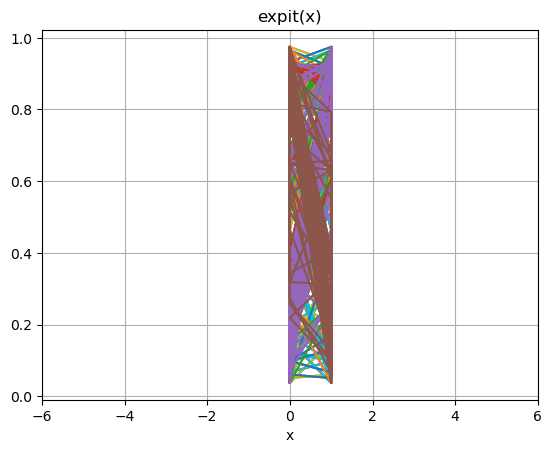

0      57
1      69
2      65
3      55
4      62
       ..
729    64
730    44
731    63
732    56
733    58
Name: Age, Length: 734, dtype: int64
(16,)
(16,)
0.9999999076307348
(16,)
()


ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

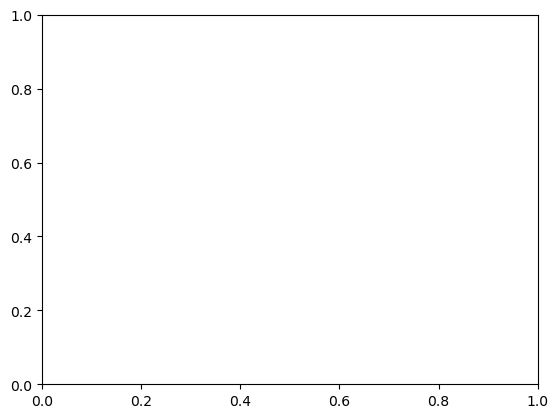

In [58]:
# plt.scatter(X,y)
# x = np.linsp.x)
y = model.predict_proba(X_test_df)
# print(x.shape, y.shape, sep="\n")
# plt.plot(model.named_steps['data-preprocessor'].transform(X_test_df), y)
plt.grid()
plt.xlim(-6, 6)
plt.xlabel('x')
plt.title('expit(x)')
# plt.show()

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta
intercept = model.named_steps['model'].theta[0]  # Assuming you have included a bias term

def sigmoid2(X, theta):
    z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))
# Create a range of x values for plotting
x_values = np.linspace(X_train_df.iloc[:, 0].min(), X_train_df.iloc[:, 0].max(), 16)
# Calculate the corresponding y values based on the decision boundary
# y_values = (-1.0 / coefficients[1]) * (coefficients[0] * x_values + intercept)
print(x_values.shape, coefficients.shape, sep="\n")
y_values = sigmoid2(x_values, coefficients)

# Plot the decision boundary
print(x_values.shape, y_values.shape, sep="\n")
plt.plot(x_values, y_values, label='Decision Boundary', color='red')

# Scatter plot for the training data
plt.scatter(X_train_df.iloc[:, 0], X_train_df.iloc[:, 1], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')

plt.xlabel(f'Feature {0 + 1}')
plt.ylabel(f'Feature {1 + 1}')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()


In [62]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

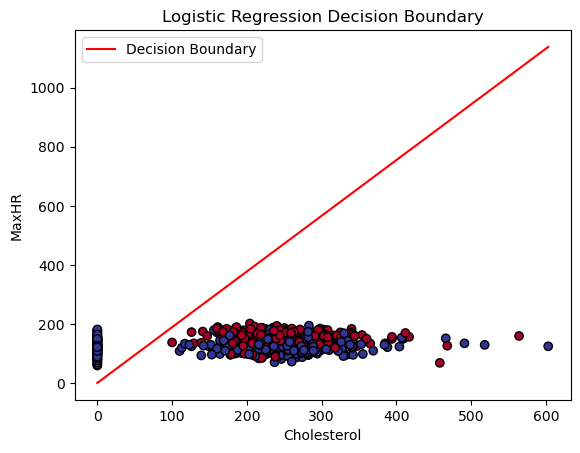

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta

# Specify the names of the columns you want to use for visualization
feature1_name = 'Cholesterol'  # Replace with the actual column name
feature2_name = 'MaxHR'  # Replace with the actual column name

# Create a range of x values for plotting
x_values = np.linspace(X_train_df[feature1_name].min(), X_train_df[feature1_name].max(), 100)

# Calculate the corresponding y values based on the decision boundary
y_values = (-1.0 / coefficients[0]) * (coefficients[1] + coefficients[2] * x_values)  # Corrected indices

# Plot the decision boundary
plt.plot(x_values, y_values, label='Decision Boundary', color='red')

# Scatter plot for the training data
# plt.scatter(x_data[:, 0], x_data[:, 1], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')  # Assuming 2D data
plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.xlabel(f'{feature1_name}')
plt.ylabel(f'{feature2_name}')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()


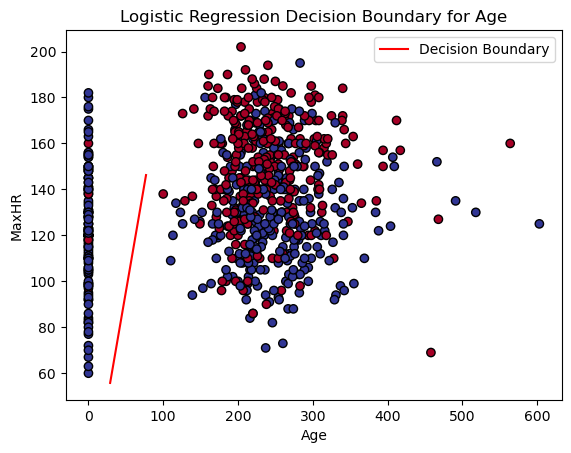

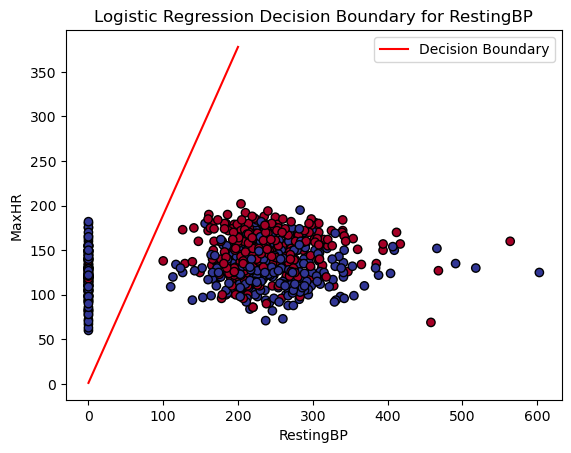

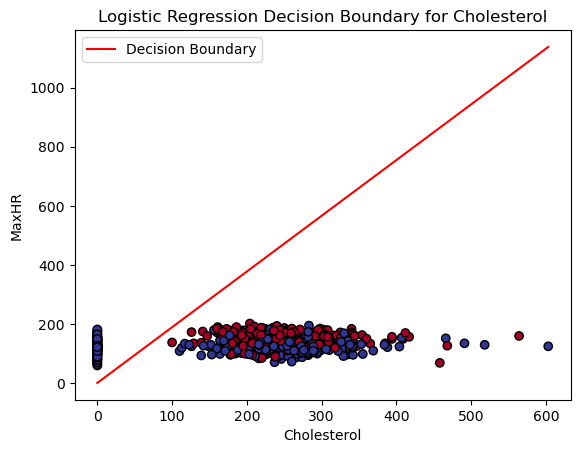

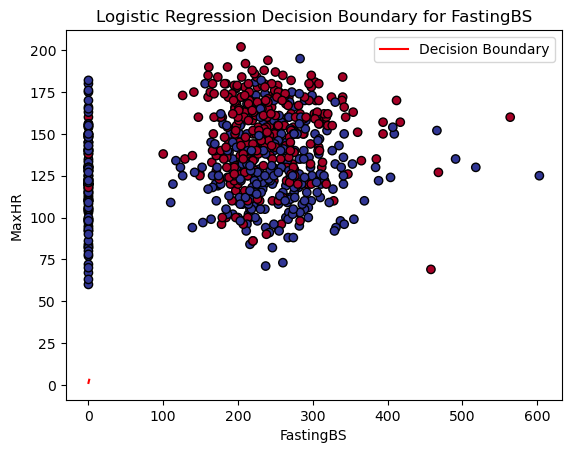

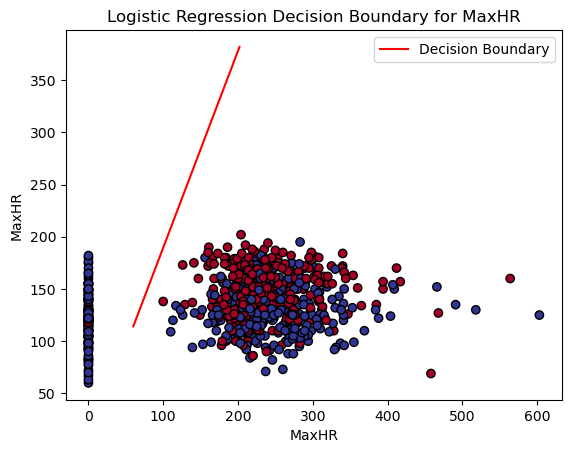

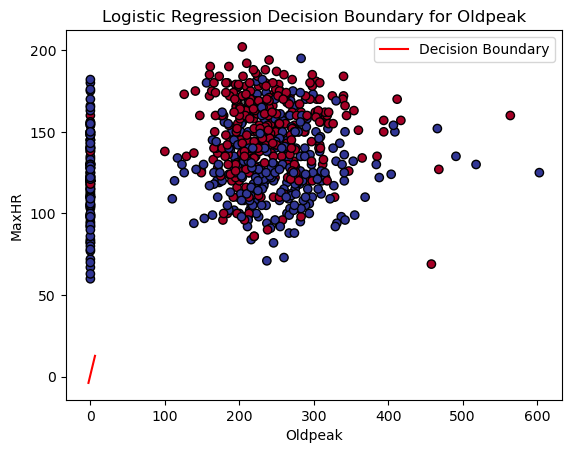

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta

# Get the list of feature names from your DataFrame
feature_names = X_train_df.columns.tolist()

# Create separate plots for each feature's decision boundary
for feature_name in feature_names:
    # Check for missing values in the column
    if X_train_df[feature_name].isna().any():
        print(f"Warning: Column '{feature_name}' contains missing values. Skipping.")
        continue

    # Check the data type of the column (should be numeric)
    if not np.issubdtype(X_train_df[feature_name].dtype, np.number):
        print(f"Warning: Column '{feature_name}' is not numeric. Skipping.")
        continue

    # Create a range of x values for plotting
    x_values = np.linspace(X_train_df[feature_name].min(), X_train_df[feature_name].max(), 100)
    x_values = np.linspace(X_train_df[feature_name].min(), X_train_df[feature_name].max(), 100)

    # Calculate the corresponding y values based on the decision boundary
    y_values = (-1.0 / coefficients[0]) * (coefficients[1] + coefficients[2] * x_values)

    # Plot the decision boundary
    plt.figure()  # Create a new plot for each feature
    plt.plot(x_values, y_values, label='Decision Boundary', color='red')

    # Scatter plot for the training data
    plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')

    ###
    # plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')
    ###

    plt.xlabel(f'{feature_name}')
    plt.ylabel(f'{feature2_name}')  # Assuming feature2_name remains constant
    plt.title(f'Logistic Regression Decision Boundary for {feature_name}')
    plt.legend()

plt.show()


In [ ]:
model.get_feature_names_out()

In [78]:
model.named_steps['data-preprocessor'].named_transformers_['onehot-transformer'].named_steps['onehot-encoder'].get_feature_names_out()

array(['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0',
       'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'], dtype=object)

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the coefficients (weights) and intercept from the model
coefficients = model.named_steps['model'].theta

# Get the transformed feature names from your preprocessor
transformed_feature_names = model.named_steps['data-preprocessor'].named_transformers_['onehot-transformer']\
    .named_steps['onehot-encoder'].get_feature_names_out(input_features=categorical_features)

# Create separate plots for each feature's decision boundary
for feature_name in transformed_feature_names:
    # Skip the selected features (assuming 'feature1_name' and 'feature2_name' are in transformed_feature_names)
    if feature_name not in [feature1_name, feature2_name]:
        # Create a range of x values for plotting
        x_values = np.linspace(X_train_df[feature_name].min(), X_train_df[feature_name].max(), 100)

        # Calculate the corresponding y values based on the decision boundary
        y_values = (-1.0 / coefficients[2]) * (coefficients[0] + coefficients[1] * x_values)

        # Plot the decision boundary
        plt.figure()  # Create a new plot for each feature
        plt.plot(x_values, y_values, label='Decision Boundary', color='red')

        # Scatter plot for the training data
        plt.scatter(X_train_df[feature1_name], X_train_df[feature2_name], c=y_train_df, cmap=plt.cm.RdYlBu, edgecolor='k')

        plt.xlabel(f'{feature_name}')
        plt.ylabel(f'{feature2_name}')
        plt.title(f'Logistic Regression Decision Boundary for {feature_name}')
        plt.legend()

plt.show()


KeyError: 'Sex_F'